# Using `ncbi.datasets` library to download and parse virus datasets

The objective of this notebook is to use the `ncbi.datasets` python library to download and extract viral genome and annotation data.

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment. 

In [1]:
import ncbi.datasets
import json
import jsonlines
import os
import csv
import zipfile
import pandas as pd
from pyfaidx import Fasta
from google.protobuf.json_format import ParseDict
import ncbi.datasets.v1alpha1.reports.virus_pb2 as virus_report_pb2
from collections import Counter
from datetime import datetime, timezone, timedelta

We will need an api object specific to retrieving viral data. To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)". 

In [1]:
virus_api = ncbi.datasets.VirusApi(ncbi.datasets.ApiClient())

## The NCBI data report

Viral genome data downloaded using the NCBI Datasets API uses the same file hierarchy as the other assembly download objects (see [Assembly Jupyter Notebook](ncbi-datasets-assembly.ipynb) to learn more). The structured zip archive contains a data report in [jsonlines](https://jsonlines.org/) format where each line is an individual json-formatted virus data report.

To illustrate how one can use these files, we will download all RefSeq genomes for the coronaviridae family and extract some genome and annotation information in tabular form. 

In [1]:
## download all refseq genomes for the coronaviridate family (taxid 11118)

taxid = 11118

viral_genomes = virus_api.virus_genome_download(
    taxid, 
    refseq_only=True, 
    exclude_sequence=False,
    _preload_content=False
)

zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(viral_genomes.data)

print(f'Download complete')
!unzip -v {zipfn}

Download complete
Archive:  ncbi_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 12-01-2020 12:54 bc3c97af  README.md
 1918659  Defl:N   665974  65% 12-01-2020 12:54 90dce184  ncbi_dataset/data/genomic.fna
  762657  Defl:N   115693  85% 12-01-2020 12:55 b97da250  ncbi_dataset/data/data_report.jsonl
    2398  Defl:N     1050  56% 12-01-2020 12:55 8d3e9da3  ncbi_dataset/data/virus_dataset.md
     292  Defl:N      162  45% 12-01-2020 12:55 69d40efa  ncbi_dataset/data/dataset_catalog.json
--------          -------  ---                            -------
 2684667           783263  71%                            5 files


The contents of the archive are shown above. We will use the `get_data_reports()` function below to extract data from the `data_report.jsonl` file and read it into the `genome_data` array.

In [1]:
def get_data_reports(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_download:
        with zip_download.open('ncbi_dataset/data/data_report.jsonl') as report_file_handle:
            with jsonlines.Reader(report_file_handle) as json_reader:
                for g in json_reader:
                    yield g
   
genome_data = []
for g in get_data_reports(zipfn):
    genome_data.append({
        'Accession': g['accession'],
        'TaxID': g['virus']['taxId'],
        'VirusName': g['virus']['sciName'],
        'Host': g.get('host', {}).get('sciName'),
        'Isolate': g.get('isolate', {}).get('name'),
        'Location': g.get('location', {}).get('geographicLocation'),
        'Length': g.get('length', 0),
        'Genes': g.get('geneCount', 0),
        'Proteins': g.get('proteinCount', 0),
        'MaturePeptides': g.get('maturePeptideCount', 0)
    })


df1 = pd.DataFrame(genome_data)
df1.head()


,Accession,TaxID,VirusName,Host,Isolate,Location,Length,Genes,Proteins,MaturePeptides
0,NC_001451.1,11120,Infectious bronchitis virus,None,None,None,27608,6,10,14
1,NC_001846.1,11138,Murine hepatitis virus,None,None,None,31357,6,8,26
2,NC_002306.3,11135,Feline infectious peritonitis virus,None,79-1146,USA,29355,10,9,0
3,NC_002645.1,11137,Human coronavirus 229E,None,None,None,27317,7,8,0
4,NC_003436.1,28295,Porcine epidemic diarrhea virus,None,None,None,28033,6,6,13


We can now quickly generate plots using the data in the dataframe. For example, a set of histograms showing the distribution of the length of the genomes, and the number of genes, proteins and mature peptides is shown below. 

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Genes'}>],
       [<AxesSubplot:title={'center':'Proteins'}>,
        <AxesSubplot:title={'center':'MaturePeptides'}>]], dtype=object)

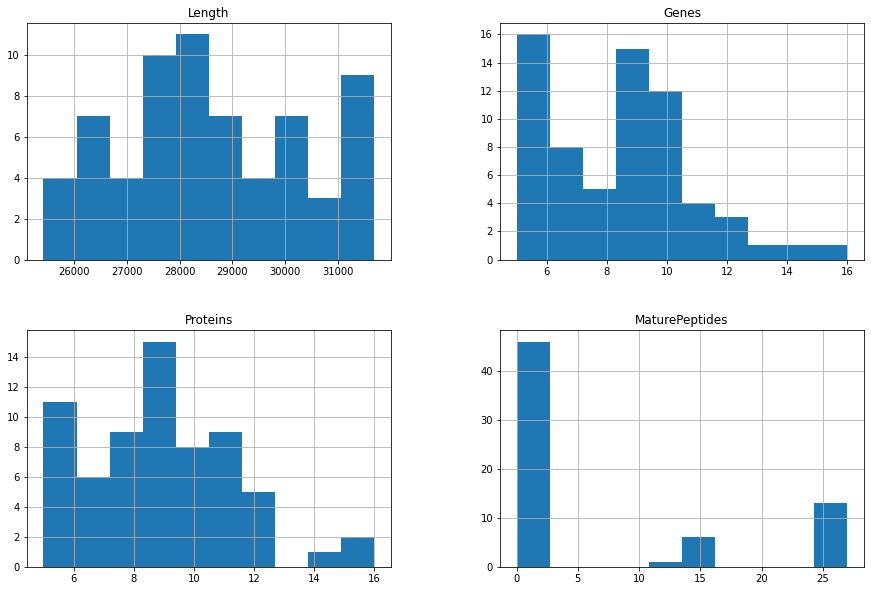

In [1]:
df1.hist(column=['Length', 'Genes', 'Proteins', 'MaturePeptides'], figsize=(15,10))

Along the same lines, data can be extracted from the `data_report.jsonl` file and saved as a tab-delimited file to use in external applications like R and Excel. Also please note that JSON stores large integers (any integer that may exceed a 32 bit signed integer in size) as a string, so you will sometimes need to explicitly convert strings to integers.

In [1]:
genome_table = [['gene_name', 'nuc_acc', 'nuc_ranges', 'prot_name', 'prot_acc', 'prot_len']]
for g in get_data_reports(zipfn):
    annot = g['annotation']
    for gene in annot.get('genes', []):
        for c in gene.get('cds', []):
            ranges = []
            for r in c['nucleotide']['range']:
                ranges.append([int(r['begin']), int(r['end'])])
            prot_len = int(c['protein']['range'][-1]['end'])
            genome_table.append([gene['name'], c['nucleotide']['accessionVersion'],
                                 ranges, c['name'], c['protein']['accessionVersion'], prot_len])

tsv_file = 'virus_genome_info.tsv'
with open(tsv_file, 'wt') as f:
    tbl = csv.writer(f, delimiter = '\t', lineterminator = os.linesep)
    tbl.writerows(genome_table)
    
print(genome_table[0])
print(genome_table[1])

['gene_name', 'nuc_acc', 'nuc_ranges', 'prot_name', 'prot_acc', 'prot_len']
['1ab', 'NC_001451.1', [[529, 12354], [12354, 20417]], 'ORF1ab polyprotein', 'NP_066134.1', 6629]


Finally, we can also use the data report to compute useful summaries, like the CDS length of each protein

In [1]:
cds_lengths = []
for g in get_data_reports(zipfn):
    annot = g['annotation']
    for gene in annot.get('genes', []):
        for c in gene.get('cds', []):
            cds_len = 0
            for r in c['nucleotide']['range']:
                cds_len += int(r['end']) - int(r['begin']) + 1
            cds_lengths.append({
                'Accession': g['accession'],
                'Gene': gene['name'],
                'Protein': c['name'],
                'CDS_Length': cds_len
            })

In [1]:
df2 = pd.DataFrame(cds_lengths)
df2.head()

,Accession,Gene,Protein,CDS_Length
0,NC_001451.1,1ab,ORF1ab polyprotein,19890
1,NC_001451.1,1ab,ORF1a polyprotein,11856
2,NC_001451.1,2,spike protein,3489
3,NC_001451.1,3,3a protein,174
4,NC_001451.1,3,3b protein,195


## Add taxid to the FASTA header

In addition to the data report, the virus archive contains one or more sequence files that can be processed together. For example, we can add a different set of attributes to the FASTA header in the sequence files. For this, we will first create a map of genomic accessions to taxids and virus names using the data in `data_report.jsonl` file. Then, we will use the `pyfaidx` python module to change the headers in `genomic.fna` FASTA file to include taxids.

In [1]:
taxids_by_accession = dict()

for genome in get_data_reports(zipfn):
    taxids_by_accession[genome['accession']] = (genome['virus']['taxId'], genome['virus']['sciName'])

In [1]:
## parse data catalog 
with zipfile.ZipFile(zipfn, 'r') as zip:
    data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))

In [1]:
with zipfile.ZipFile(zipfn, 'r') as zip:
    data = zip.read('ncbi_dataset/data/genomic.fna')
    with open('genomic.fna', 'wb') as f:
        f.write(data)

with open('genomic.out.fna', 'w') as f:
    genomic_seqs = Fasta('genomic.fna')
    for g in genomic_seqs:
        (taxid, org_name) = taxids_by_accession[g.name]
        header = '>' + '|'.join([g.name, str(taxid), org_name, '\n'])
        f.write(header)
        f.write(genomic_seqs[g.name][:].seq + '\n')

## Fetch all SARS-CoV-2 genomes submitted in the past 7 days

Narrowing our focus a little, if we are interested in just SARS-CoV-2 genomes they too can be downloaded using `ncbi.datasets` library as shown below. Here, for example, we will restrict the data returned to only those genomes that were submitted in the past 7 days. 

A python datetime object is created with the desired date and provided to the api instance. 

In [1]:
## to fetch all genomes submitted in the past 7 days
t = 7
d = datetime.now(timezone.utc) - timedelta(days=t)
taxid = 2697049

print(f'Download genomes release since: {d}')
cov2_genomes = virus_api.virus_genome_download(
    taxid, 
    released_since = d.isoformat(),
    include_annotation_type=['PDB_FILES'],
    _preload_content=False)

print('Start downloading ...')
zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(cov2_genomes.data)
print('Finished.')
!unzip -v {zipfn}

Download genomes release since: 2020-11-24 18:13:57.217995+00:00
Start downloading ...
Finished.
Archive:  ncbi_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 12-01-2020 13:13 bc3c97af  README.md
 2560357  Defl:N   868651  66% 12-01-2020 13:13 e5c2f3b2  ncbi_dataset/data/genomic.fna
 2448777  Defl:N   227885  91% 12-01-2020 13:13 23ec1fef  ncbi_dataset/data/data_report.jsonl
    2398  Defl:N     1050  56% 12-01-2020 13:13 8d3e9da3  ncbi_dataset/data/virus_dataset.md
 2088828  Defl:N   586156  72% 12-01-2020 13:13 ad7faaf4  ncbi_dataset/data/pdb/6VYB.pdb
  758727  Defl:N   236717  69% 12-01-2020 13:13 d68f7342  ncbi_dataset/data/pdb/6VYO.pdb
   66582  Defl:N    19013  71% 12-01-2020 13:13 daa19637  ncbi_dataset/data/pdb/6W37.pdb
  675378  Defl:N   209771  69% 12-01-2020 13:13 5fd9e206  ncbi_dataset/data/pdb/6W4H.pdb
 1250964  Defl:N   397566  68% 12-01-2020 13:13 6bb

Now, we can use the information in the data report to tabulate information such as the number of genomes by collection date and georaphic location:

In [1]:
# Warning: This step can take several minutes to execute, depending on the size of the request.  
#          You may want ot shorten the time window to less than 7 days.

coll_by_month = Counter()
geo_by_date = []

for g in get_data_reports(zipfn):
    coll_date = g.get('isolate', {}).get('collectionDate')
    if coll_date:
        coll_date = '/'.join(coll_date.split('-')[:2])
        coll_by_month[coll_date] += 1

        geo_by_date.append({
            'Date': g['isolate']['collectionDate'],
            'Location': g.get('location', {}).get('geographicLocation', '').split(':')[0]
        })    

print(coll_by_month)

Counter({'2020/04': 33, '2020/10': 25, '2020/11': 18, '2020/05': 14, '2020/06': 2, '2020/07': 1, '2020/03': 1, '2020/09': 1, '2020/08': 1})


Now, we can use the information in the data report to tabulate information such as the number of genomes by collection date and georaphic location as shown below. 

<AxesSubplot:>

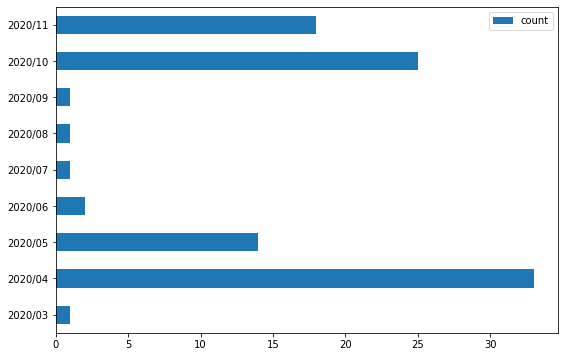

In [1]:
df = pd.DataFrame.from_dict(coll_by_month, orient='index', columns=['count']).sort_index()
df.plot(kind = 'barh', y='count', figsize=(9,6))

In [1]:
df3 = pd.DataFrame(geo_by_date)
df3.head()

,Date,Location
0,2020-10-26,Ecuador
1,2020-07-20,Ecuador
2,2020-11-04,USA
3,2020-11-04,USA
4,2020-11-04,USA


<AxesSubplot:>

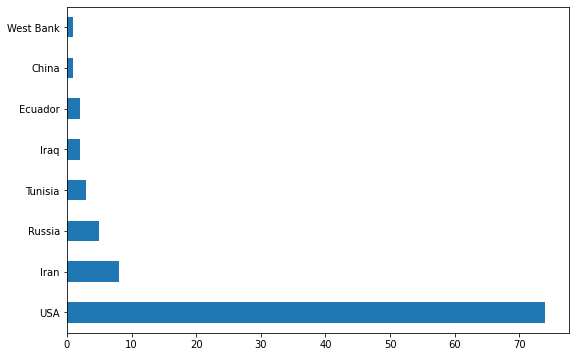

In [1]:
pd.value_counts(df3['Location']).plot.barh(figsize=(9,6))